# **Standard integration**

The objective is to concatenate some datasets of scRNA-seq mouse embryos stage E4.5 because of lower number of cells. We interessed us in Lefty1, a gene for A-P axis establishment during gastrulation (E6.5) but it's expressed at E4.5 but in poor number of cells in a embryo (~5 cells)

In [88]:
import pandas as pd
import scanpy as sc
import anndata as ad
from collections import defaultdict
import matplotlib as mpl
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np

In [89]:
sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=150, facecolor='white', fontsize=12)

scanpy==1.10.2 anndata==0.10.8 umap==0.5.6 numpy==1.26.4 scipy==1.13.1 pandas==2.2.2 scikit-learn==1.4.2 statsmodels==0.14.2 igraph==0.11.5 louvain==0.8.2 pynndescent==0.5.13


**Read the object**

In [90]:
adata = ad.read_h5ad('Objects/object_1_Deng_filtered_1_2_Chen_filtered_1_3_Mohammed_filtered_1_4_Nowo_filtered_1_4bis_Nowo_filtered_1_5_Posfai_filtered_1_6_Arg_filtered_1.h5ad')

**Normalize data**

In [91]:
sc.pp.normalize_total(adata, target_sum = 1e4)

normalizing counts per cell
    finished (0:00:00)


**Log on data**

In [92]:
sc.pp.log1p(adata)

**Stock data logs**

In [93]:
adata.raw = adata

**Scale the data**

In [94]:
sc.pp.scale(adata)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


**Highly variable genes**

In [95]:
sc.pp.highly_variable_genes(adata)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


**Run PCA**

In [96]:
sc.tl.pca(adata)

computing PCA
    with n_comps=50
    finished (0:00:00)


**PCA plot**

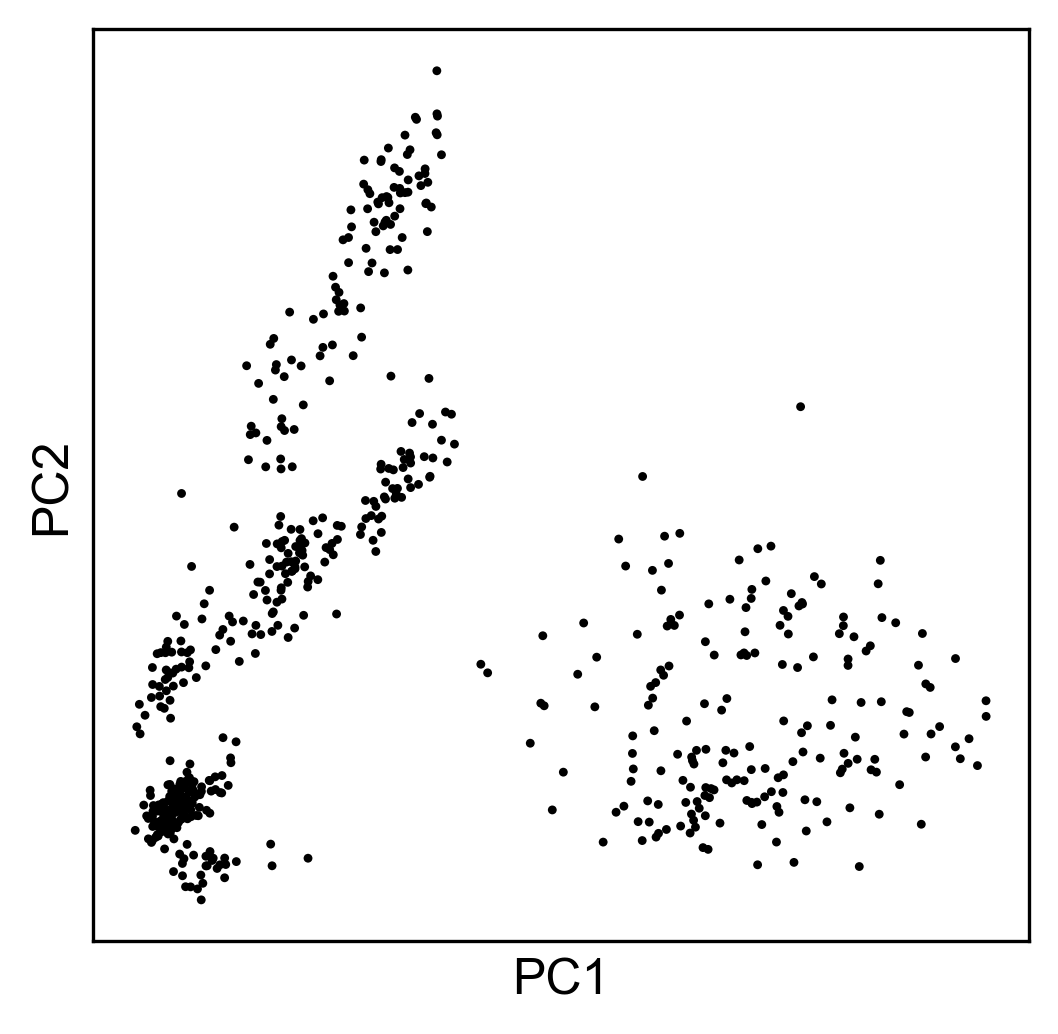

In [97]:
sc.pl.pca(adata, size=18, na_color = 'black')

**Elbow plot**

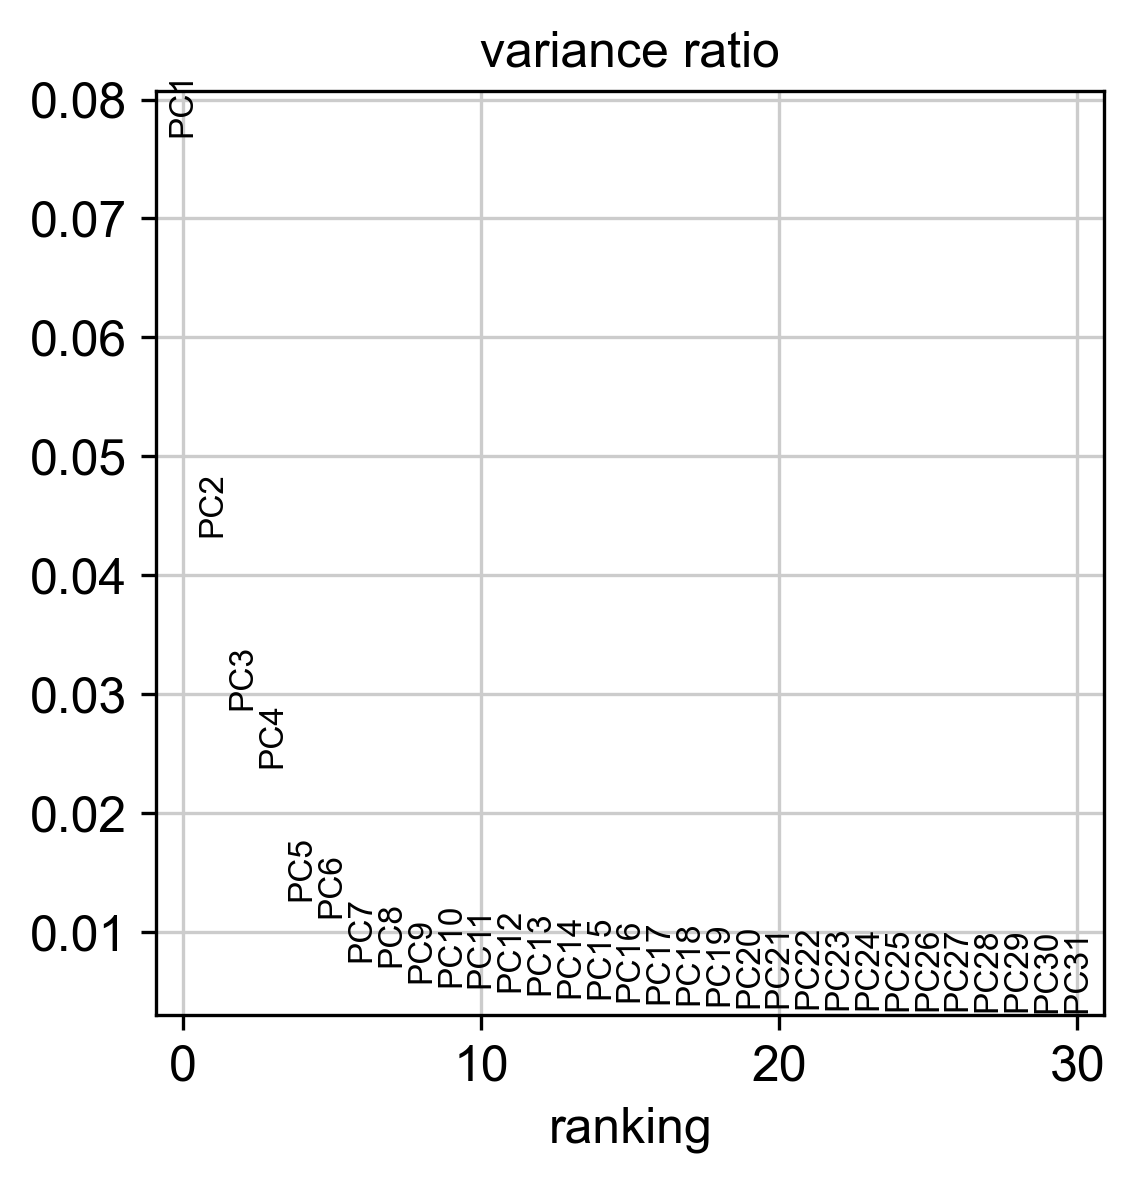

In [98]:
sc.pl.pca_variance_ratio(adata)

**Run harmony**

I use harmony to remove batch effect.

In [99]:
sc.external.pp.harmony_integrate(adata, 'dataset', theta = 1, max_iter_harmony = 10, nclust = 3)

2024-07-04 13:33:03,206 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
C:\Users\learogue\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
2024-07-04 13:33:04,377 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-07-04 13:33:04,377 - harmonypy - INFO - Iteration 1 of 10
2024-07-04 13:33:04,436 - harmonypy - INFO - Iteration 2 of 10
2024-07-04 13:33:04,508 - harmonypy - INFO - Iteration 3 of 10
2024-07-04 13:33:04,538 - harmonypy - INFO - Converged after 3 iterations


**Save new PCA**

In [100]:
adata.obsm['X_pca'] = adata.obsm['X_pca_harmony']

**Find neighbors**

In [101]:
sc.pp.neighbors(adata, n_neighbors=50, n_pcs=20)

computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


**Make groups**

In [102]:
sc.tl.louvain(adata, resolution=0.8)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 3 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


**Run UMAP**

In [103]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)


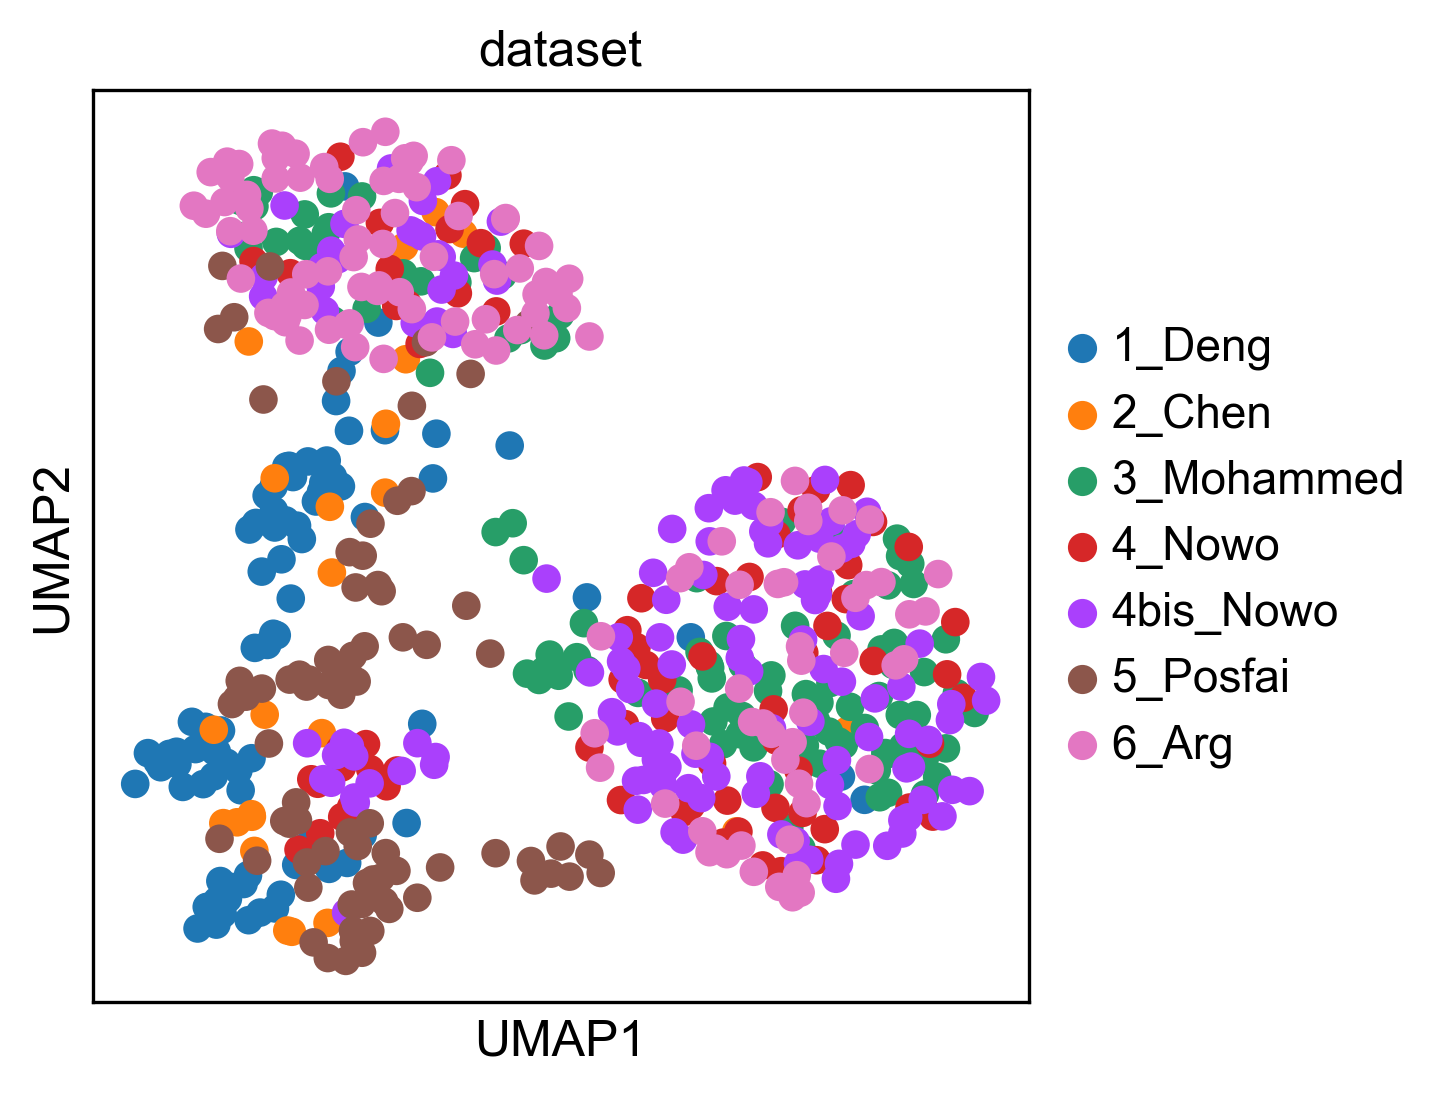

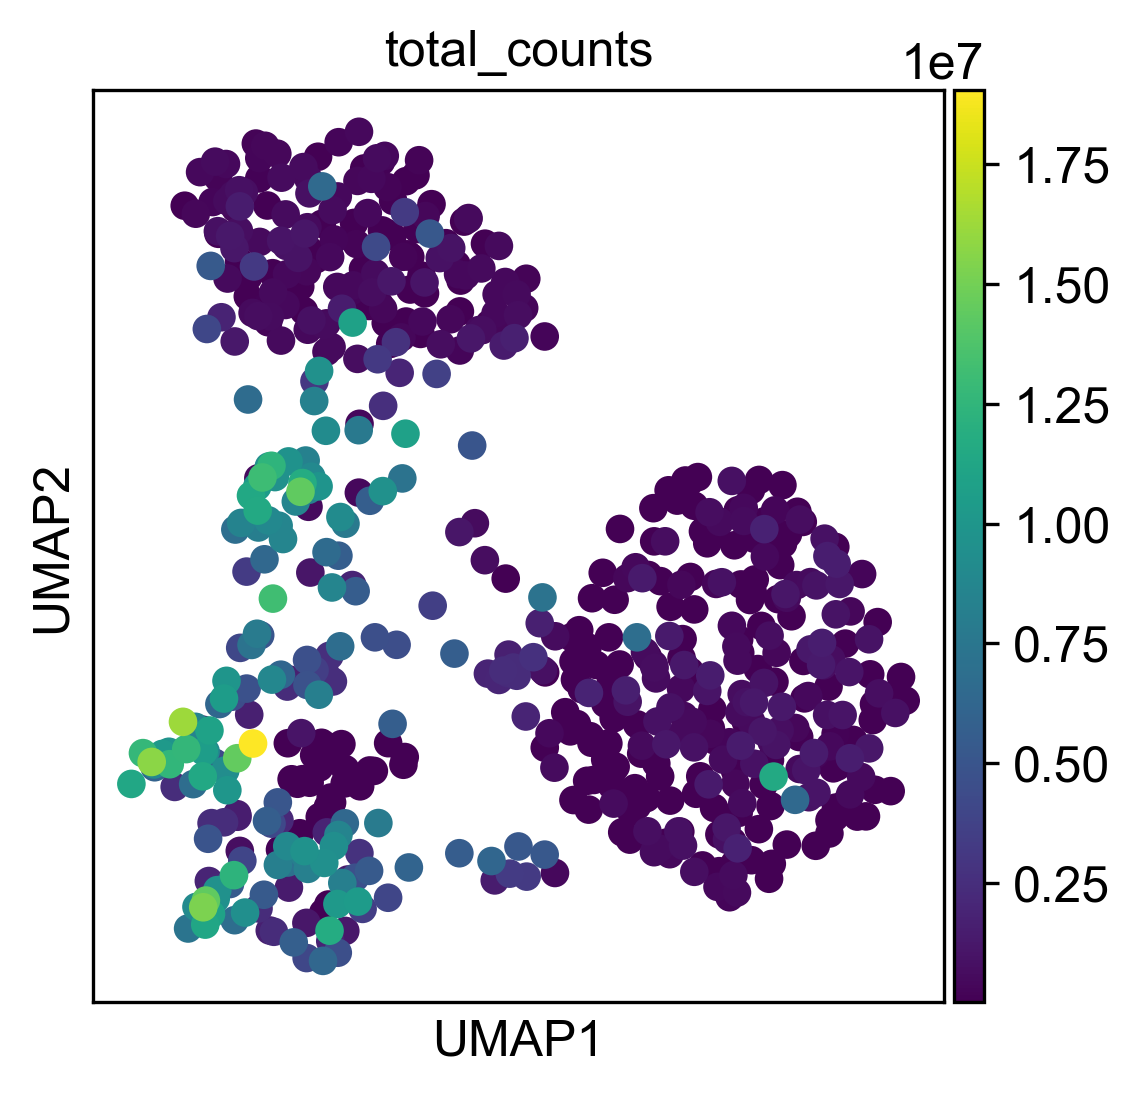

In [104]:
sc.pl.umap(adata, color=['dataset'])
sc.pl.umap(adata, color=['total_counts'])

**Primitive endoderm markers**

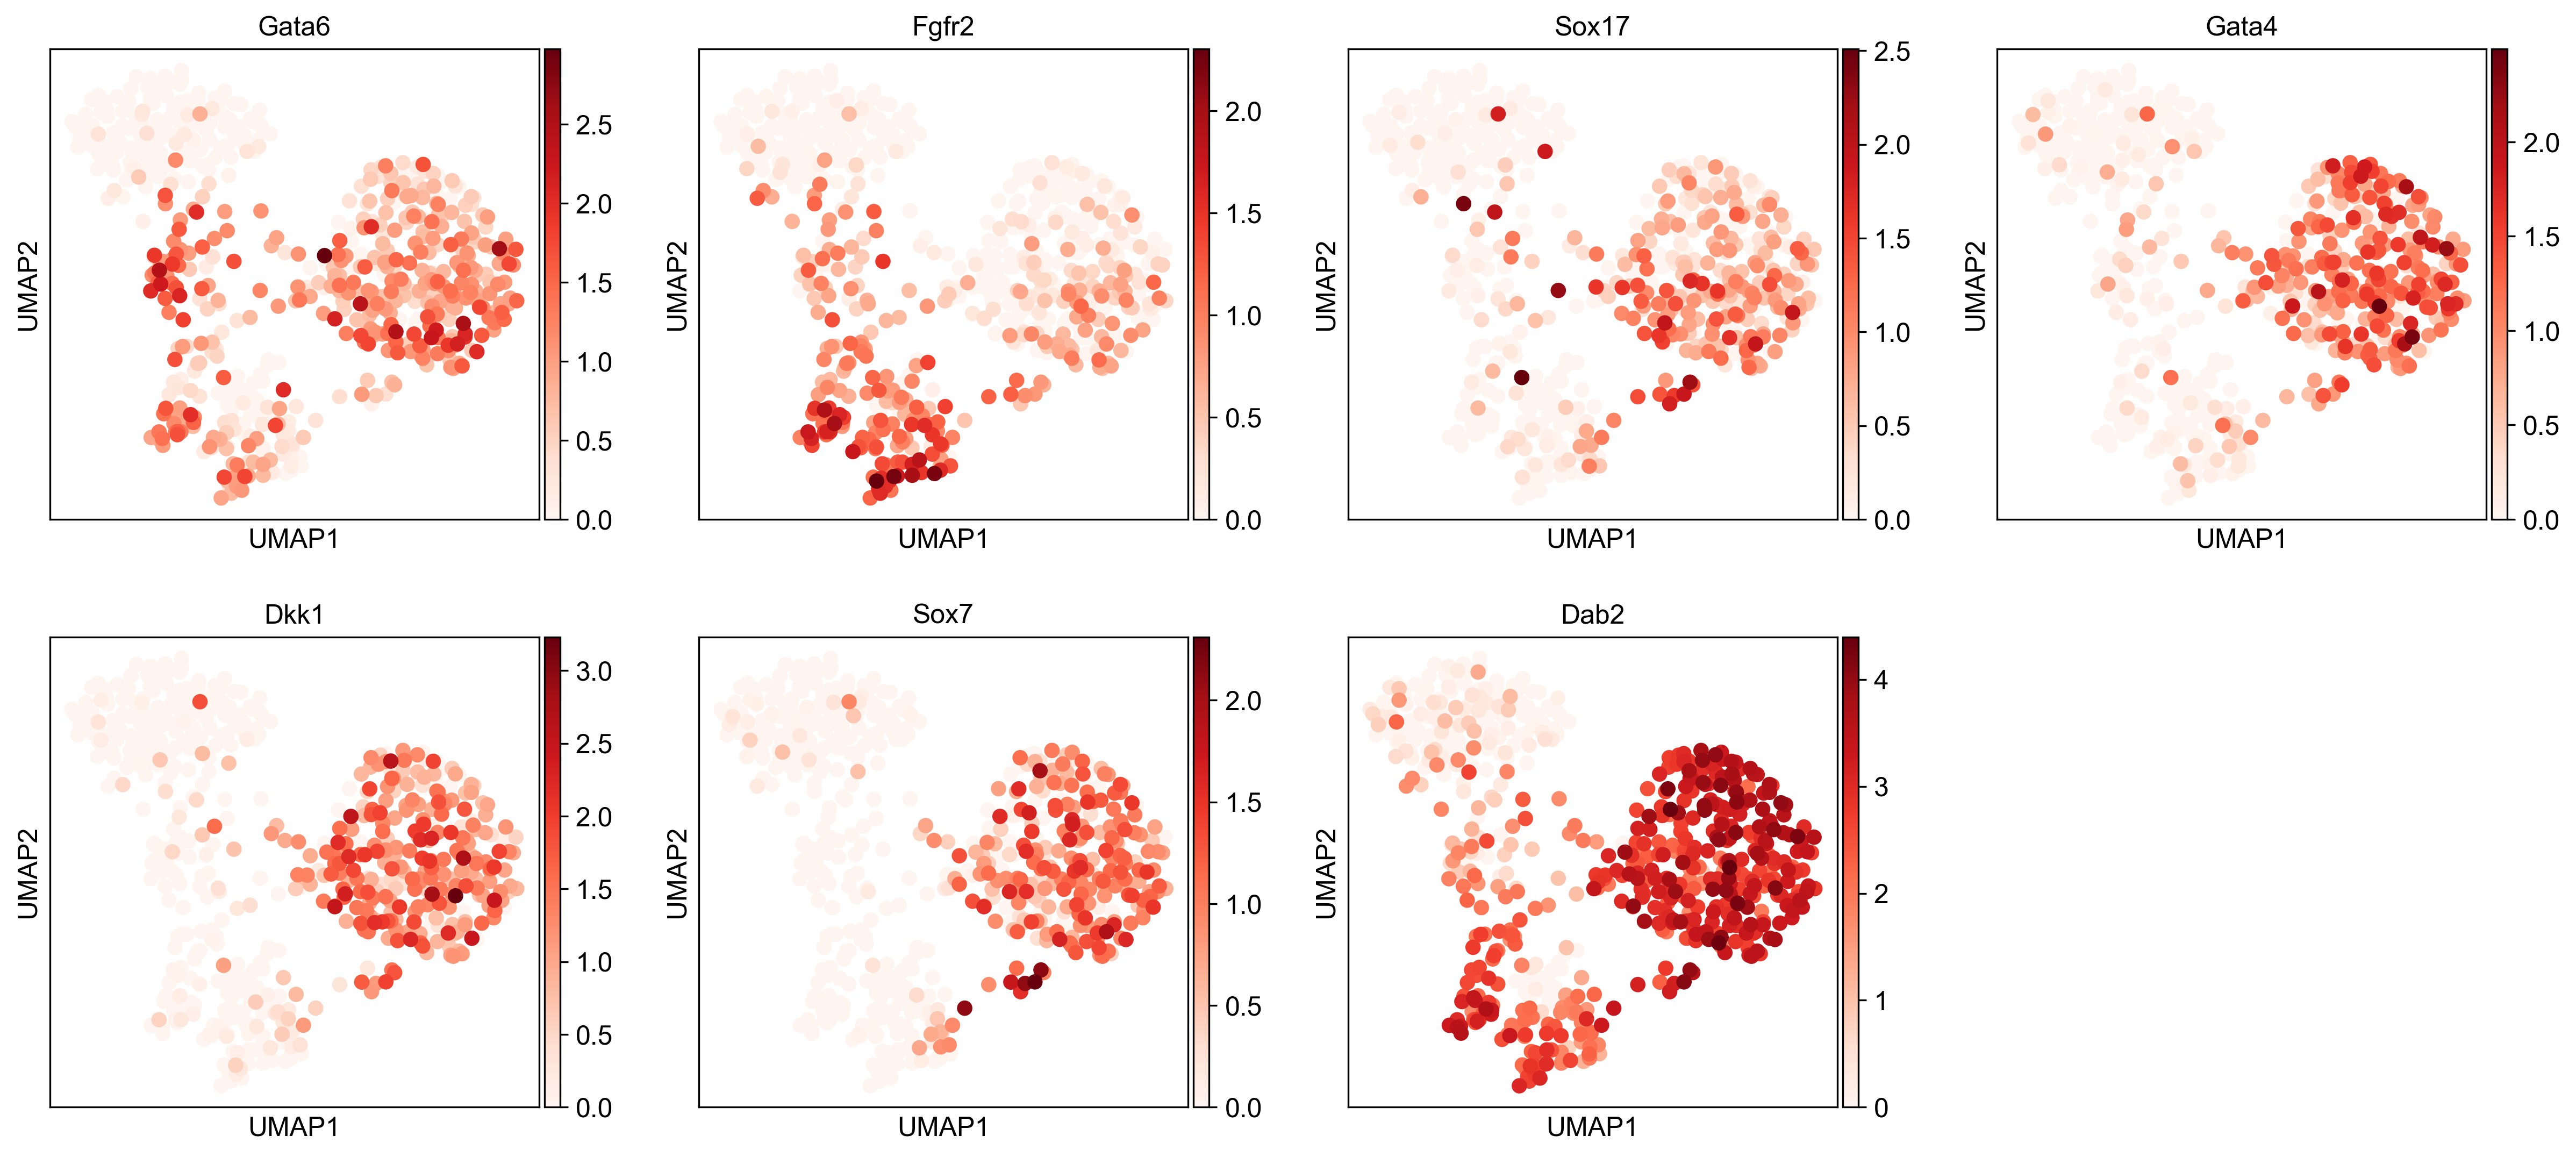

In [50]:
sc.pl.umap(adata, color=['Gata6', 'Fgfr2', 'Sox17', 'Gata4', 'Dkk1', 'Sox7', 'Dab2'], legend_loc='on data', color_map=mpl.cm.Reds)

**Epiblast markers**

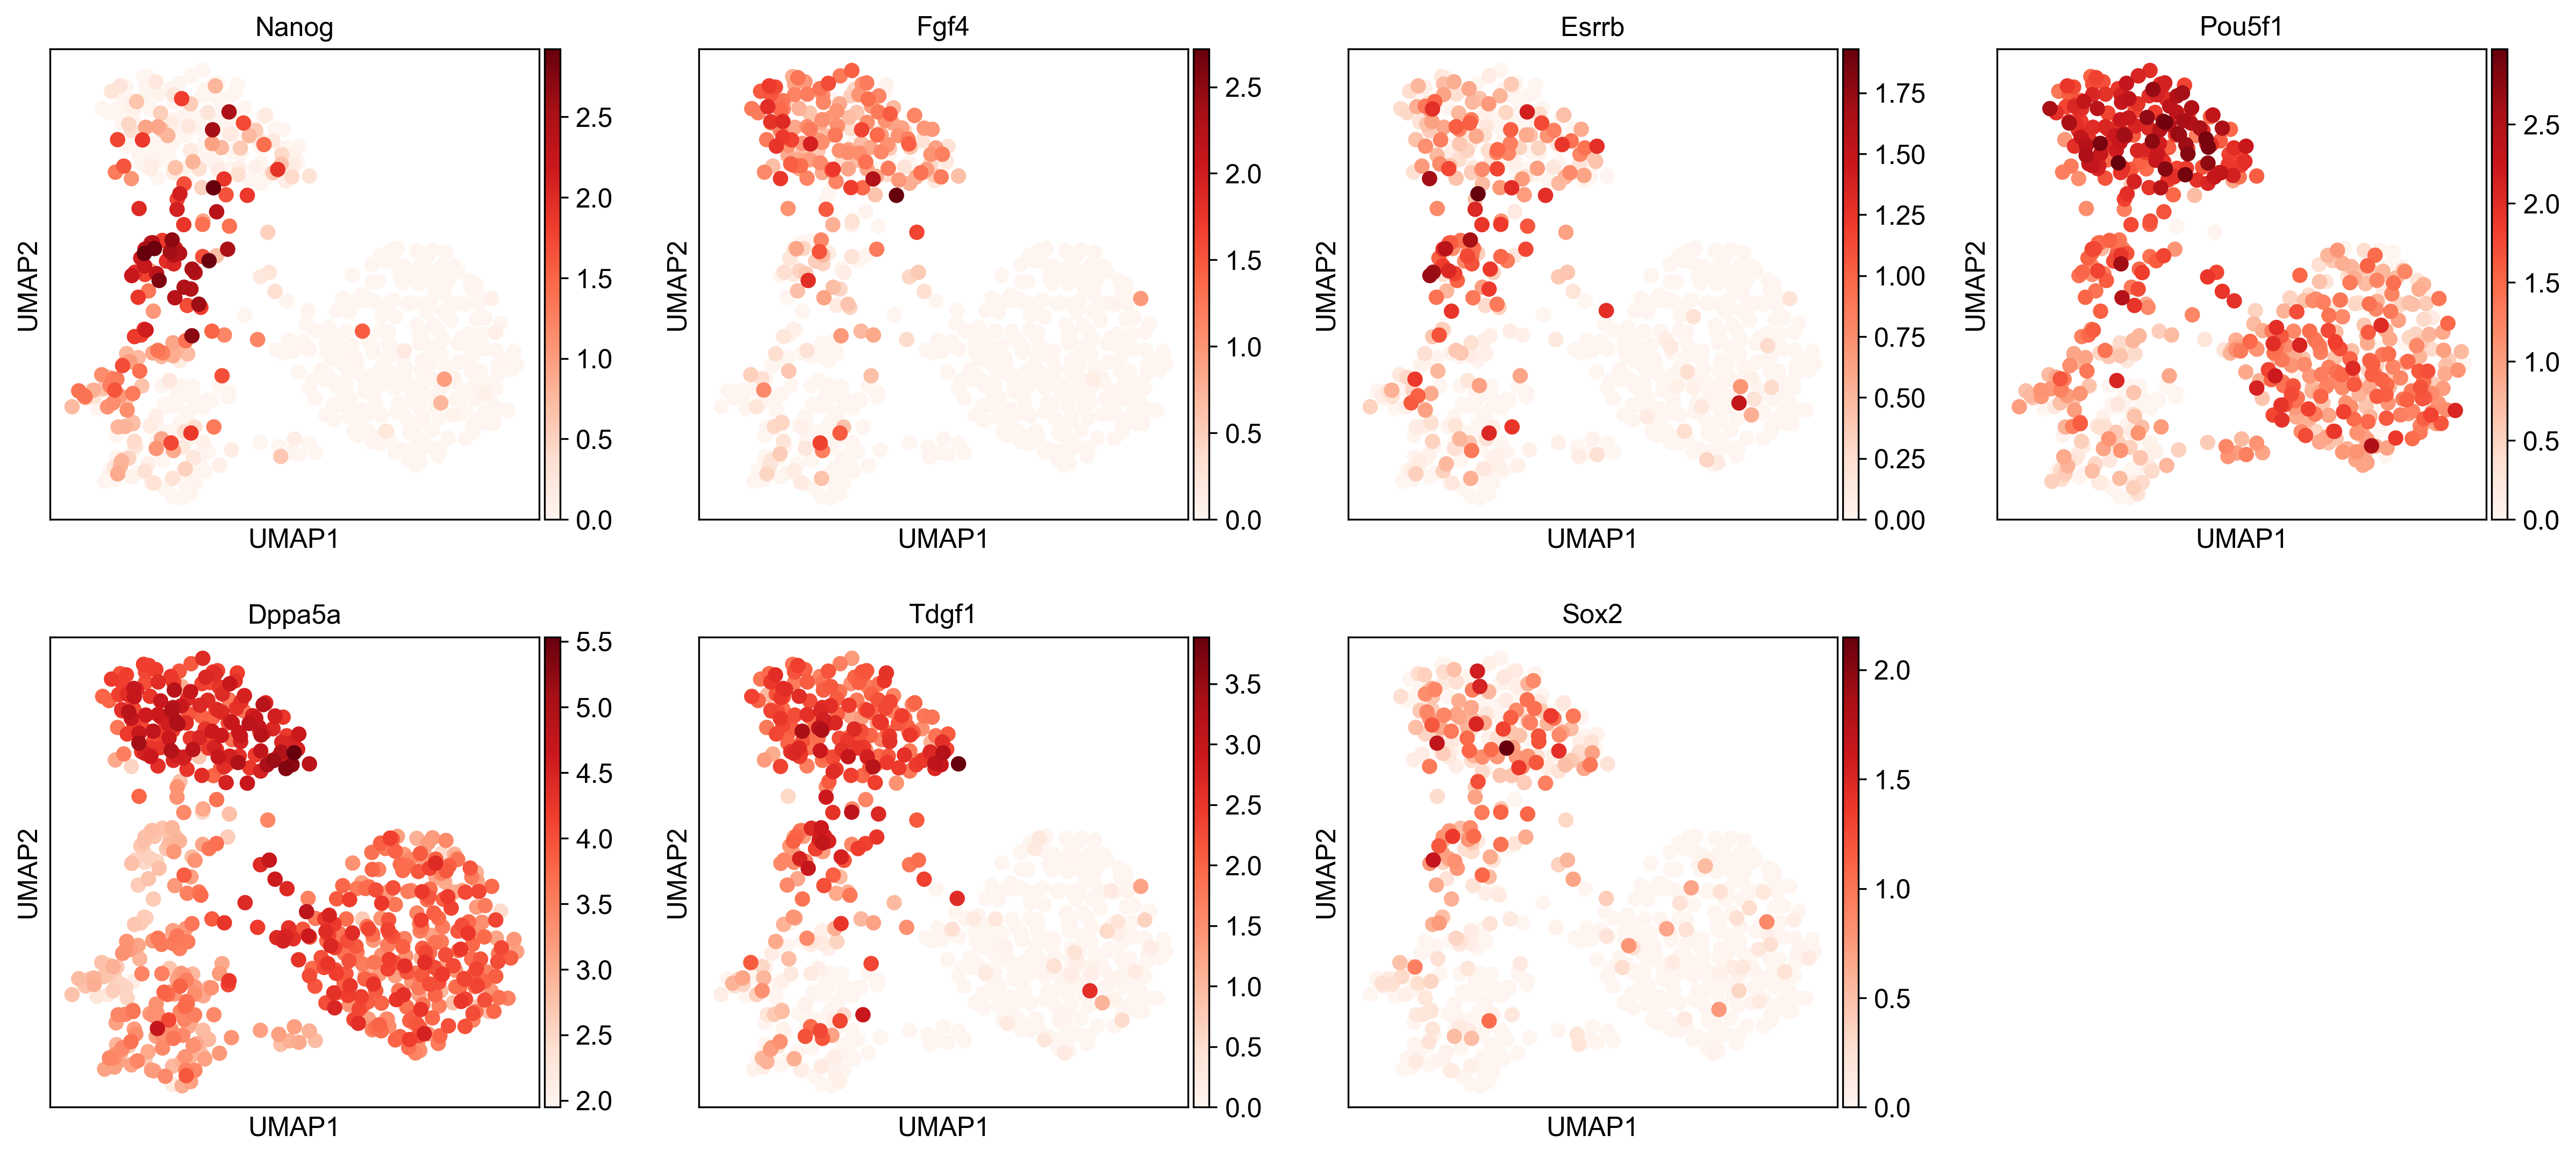

In [106]:
sc.pl.umap(adata, color=['Nanog', 'Fgf4', 'Esrrb', 'Pou5f1', 'Dppa5a', 'Tdgf1', 'Sox2'], legend_loc='on data', color_map=mpl.cm.Reds)

**Trophectoderm markers**

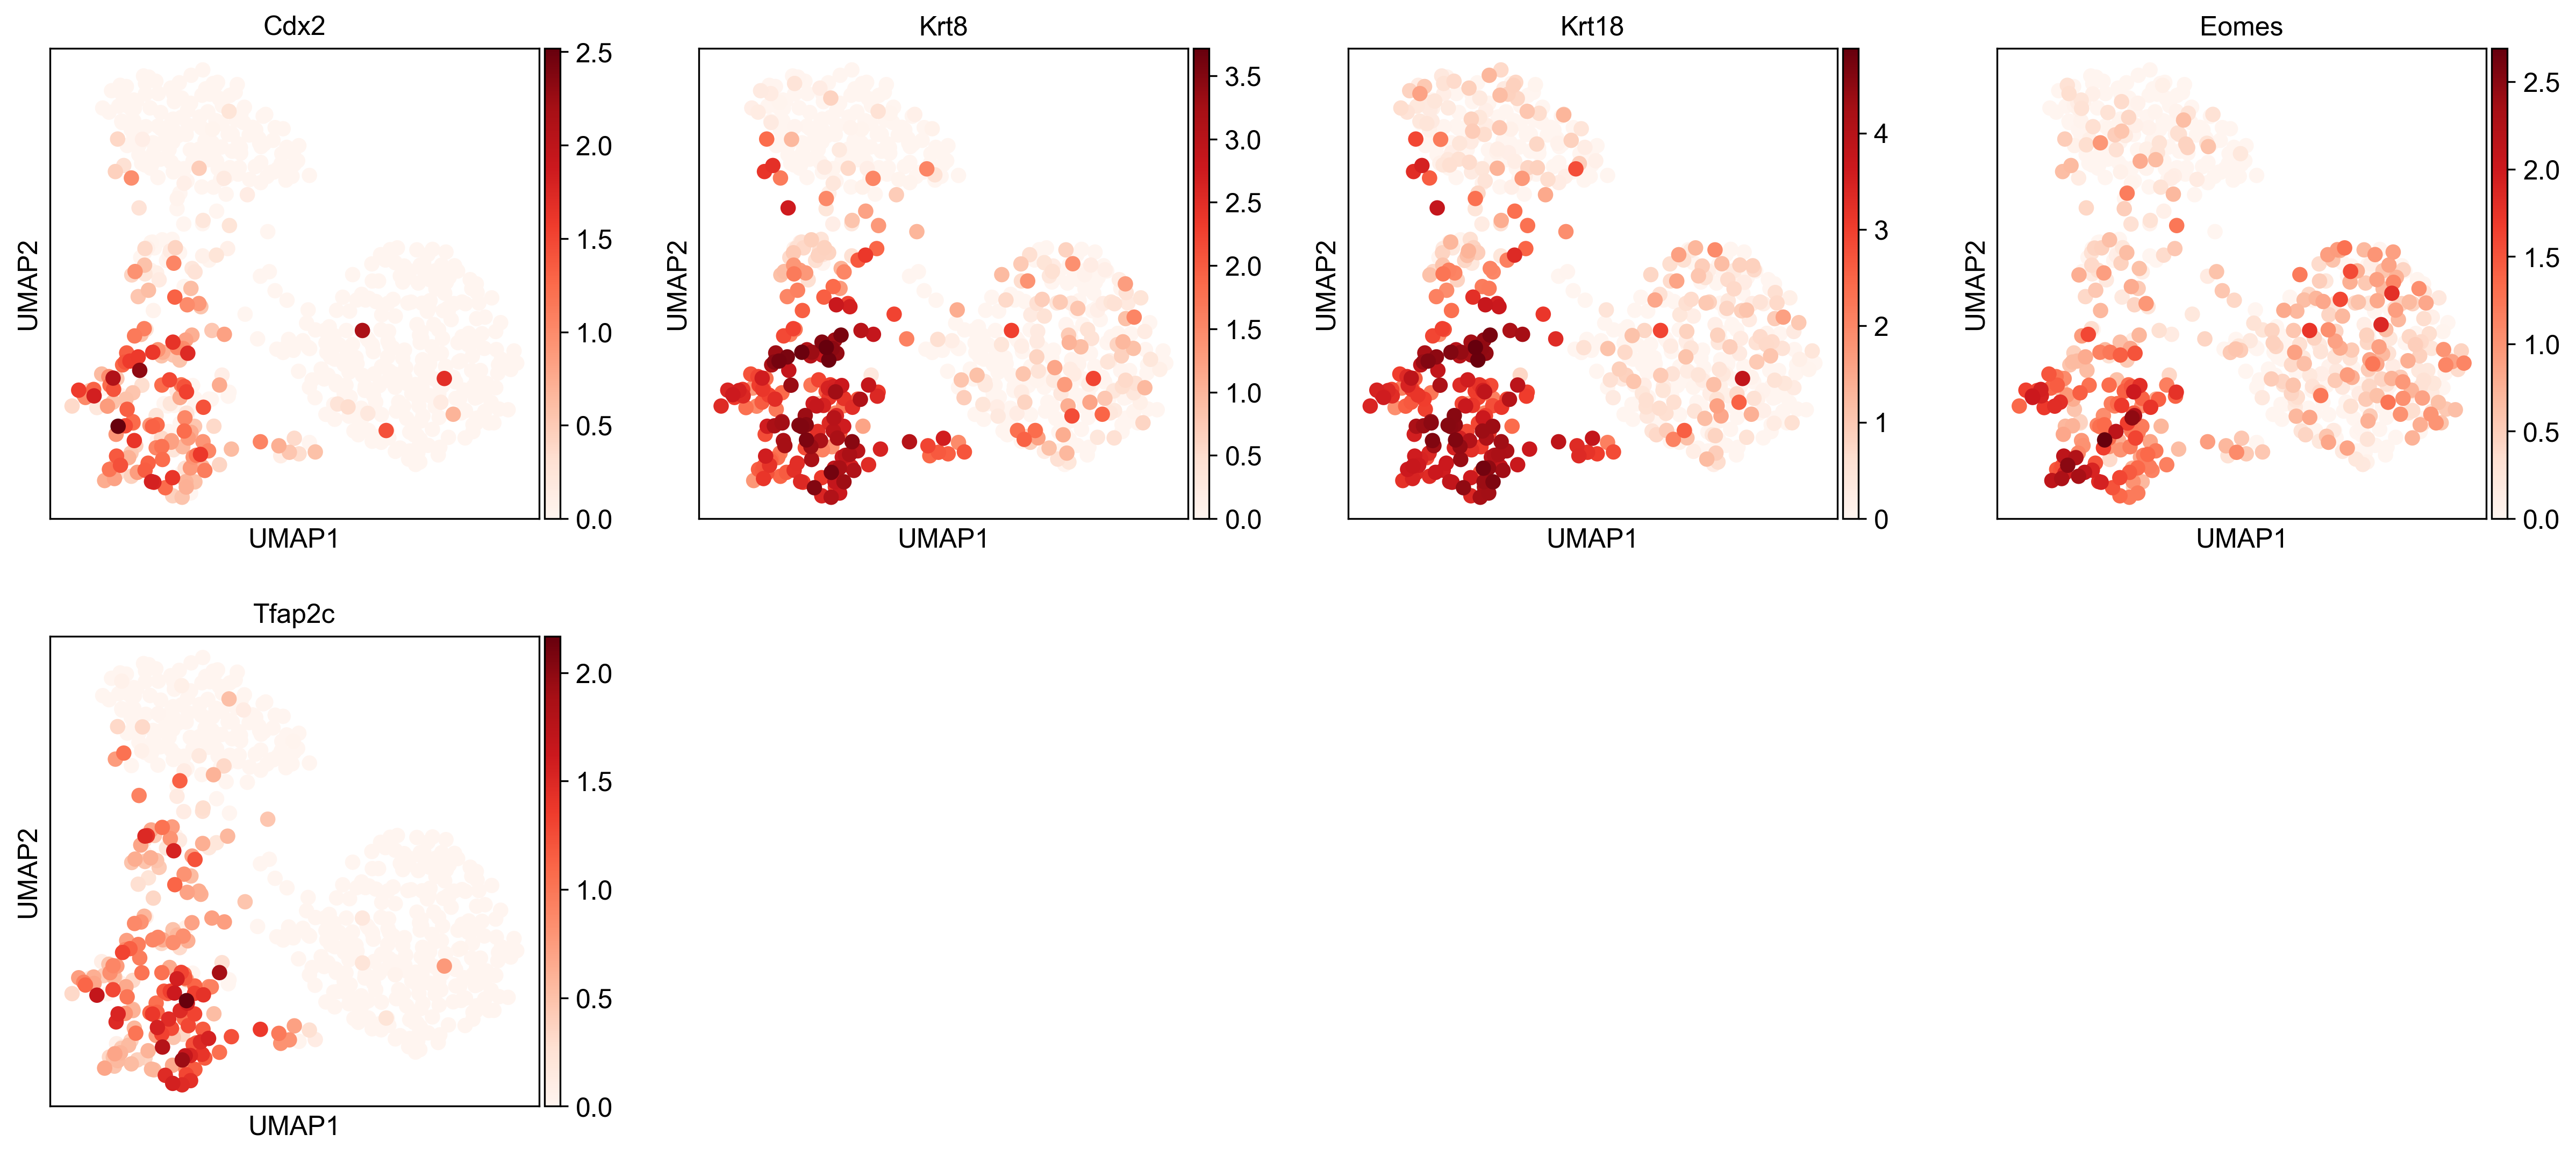

In [107]:
sc.pl.umap(adata, color=['Cdx2', 'Krt8', 'Krt18', 'Eomes', 'Tfap2c'], legend_loc='on data', color_map=mpl.cm.Reds)

**Lefty1 and Lefty2**

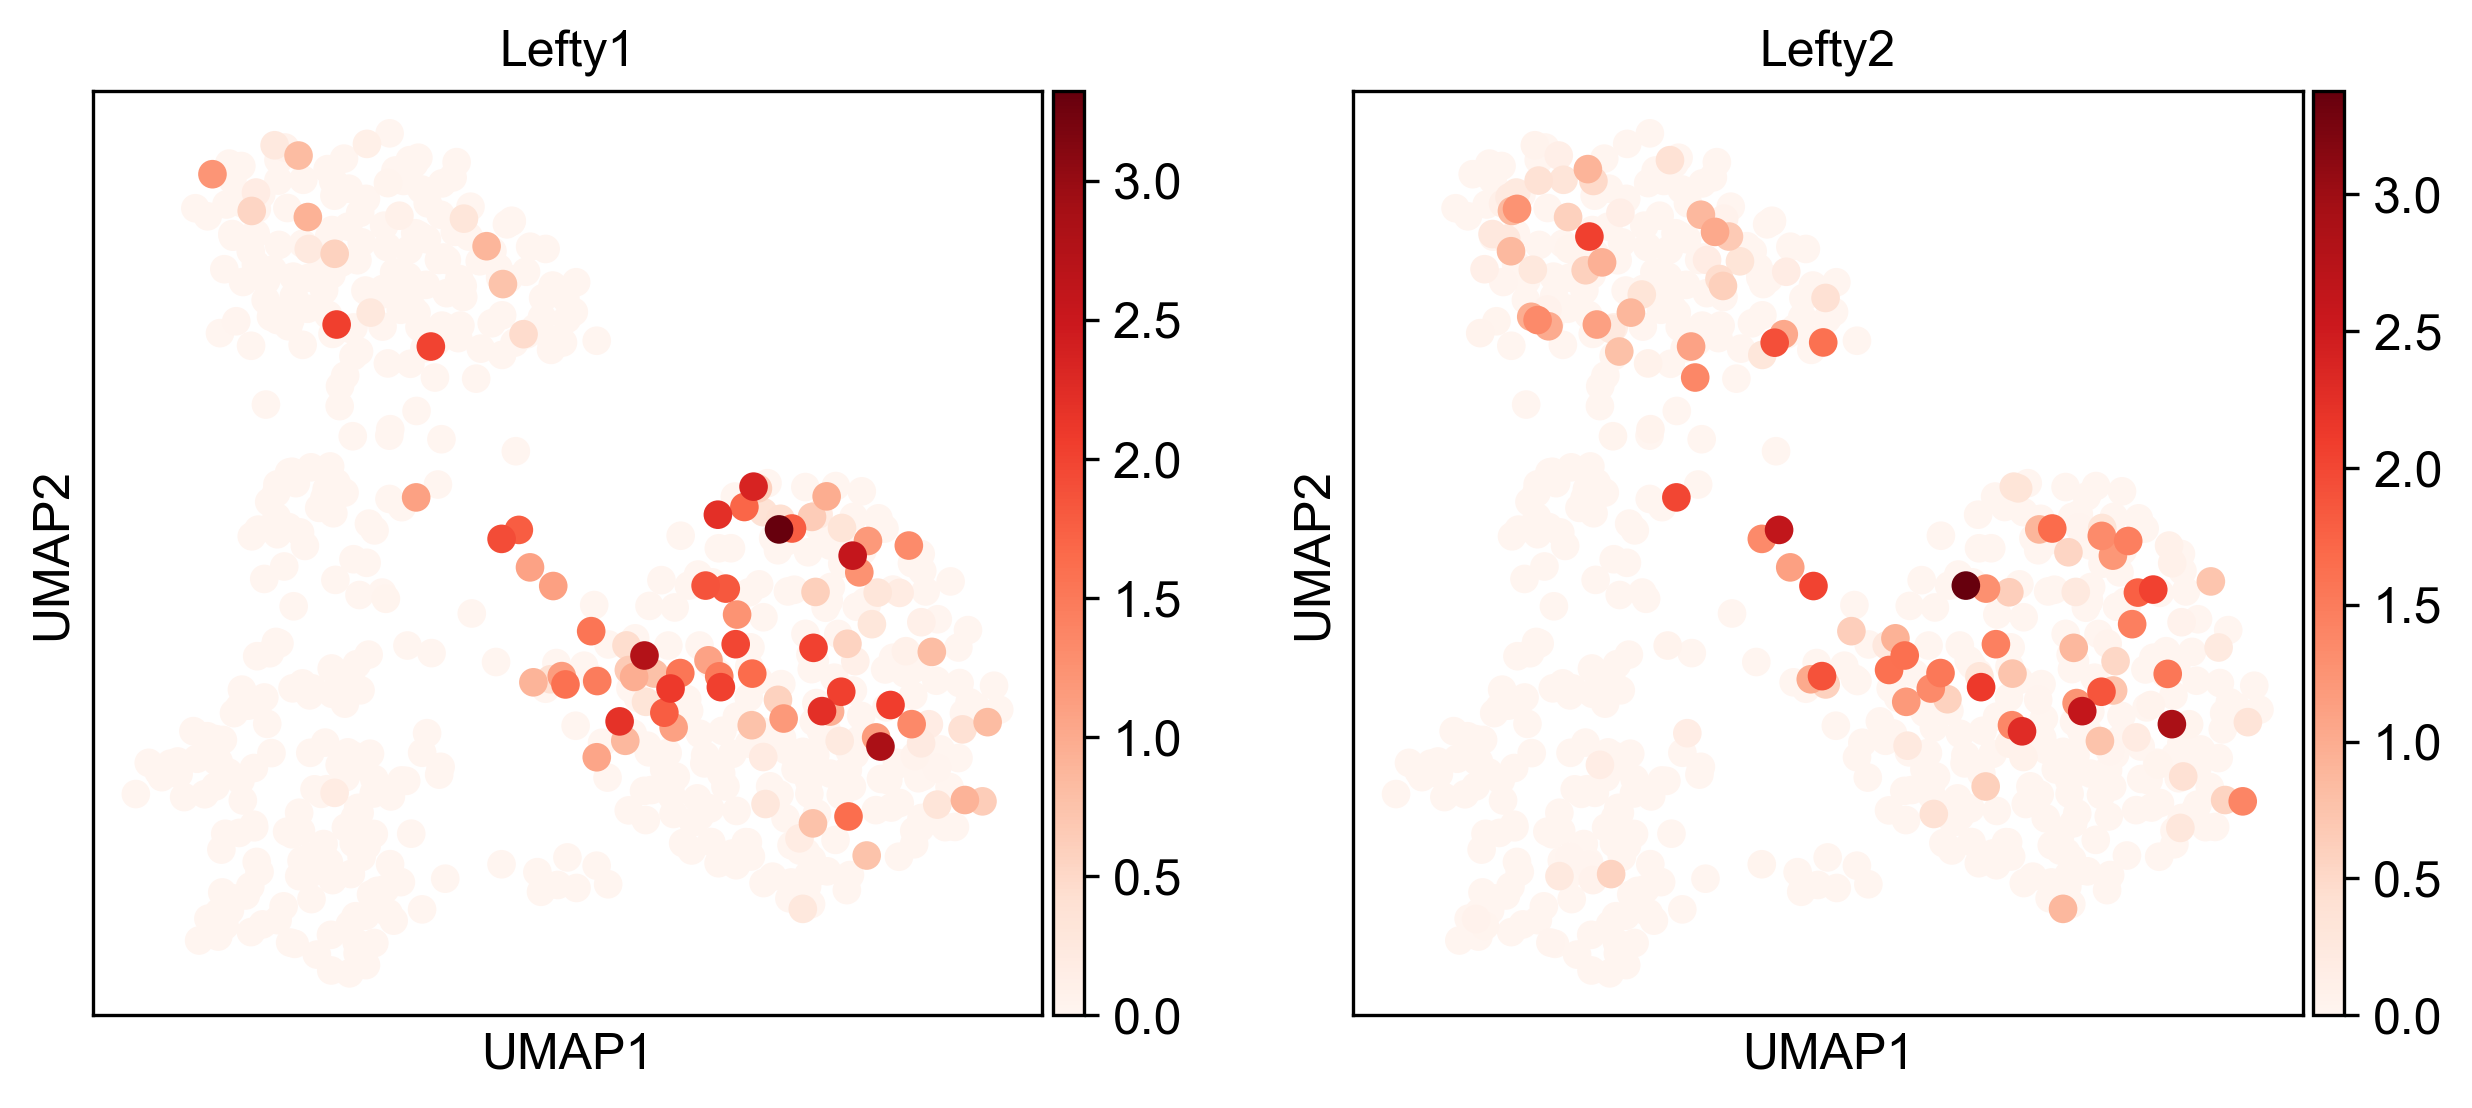

In [108]:
sc.pl.umap(adata, color=['Lefty1', 'Lefty2'], legend_loc='on data', color_map=mpl.cm.Reds)

**Add cell types**

In [109]:
adata.obs['cell_type'] = adata.obs['louvain']
new_cluster_names = ['PrE', 'Epi', 'TE']
adata.rename_categories("cell_type", new_cluster_names)

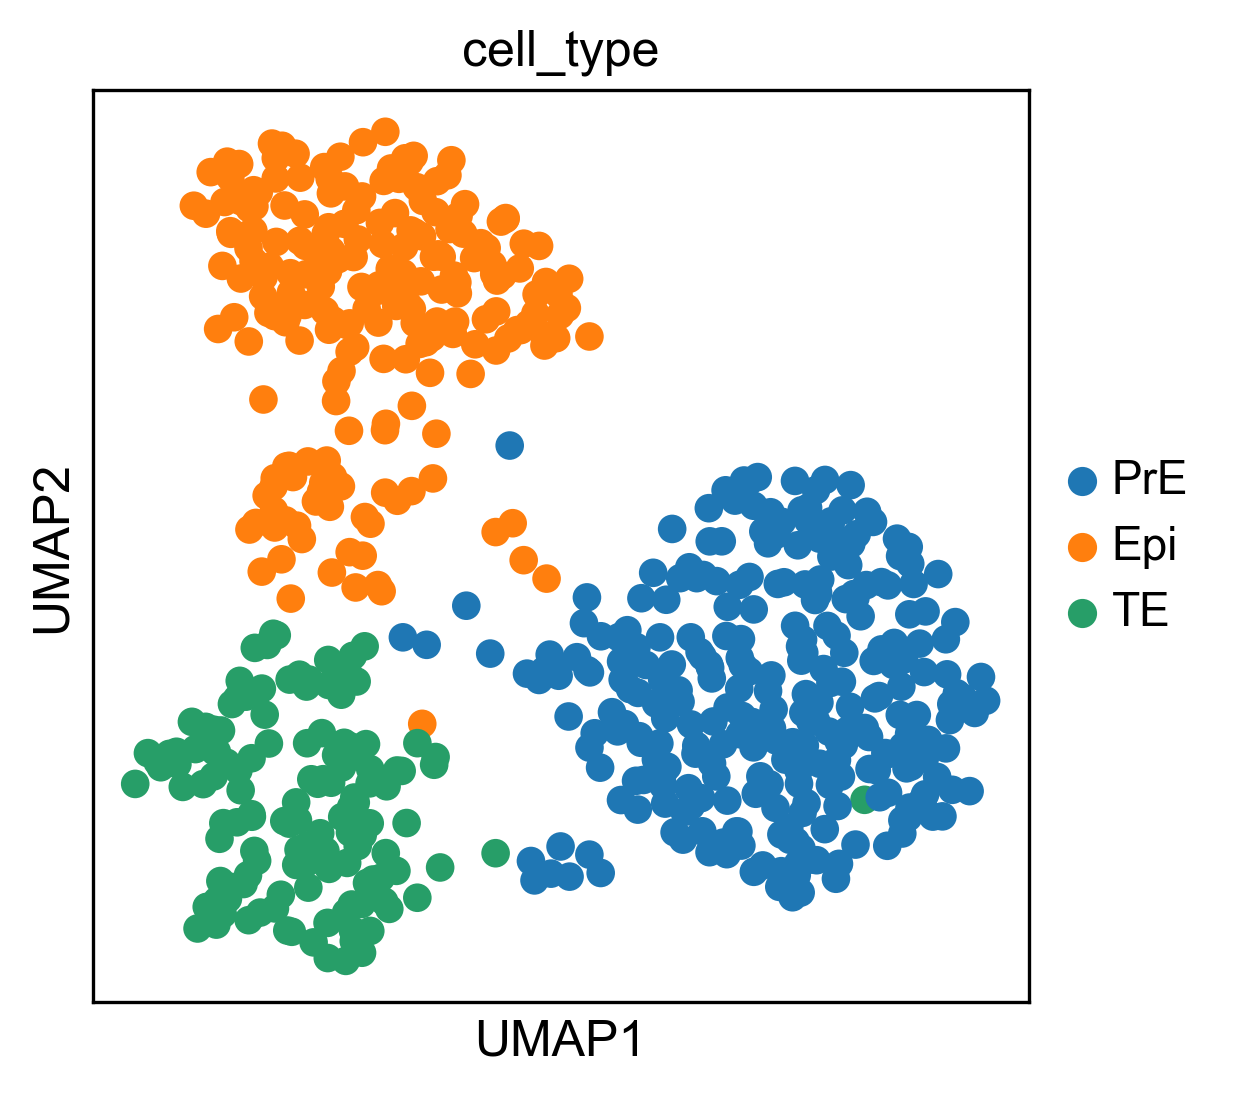

In [110]:
sc.pl.umap(adata, color=['cell_type'])

# **Lefty1 Analysis**

**Number of cells Lefty1 + per dataset**

In [121]:
# Select only Lefty1
lefty = adata[:, 'Lefty1']

In [120]:
leftypos = lefty[lefty.X>0, :]

In [119]:
leftypos_PrE = leftypos[leftypos.obs['cell_type']=='PrE', :]

In [60]:
# Take cells' names and datasets' names
leftypos_cell = leftypos_PrE.obs['dataset']
d = leftypos_cell.to_dict()

In [61]:
# dictionnary with in key name of the dataset and value = list of cells
d_nb_cells = defaultdict(list)
for cell, batch in d.items():
    d_nb_cells[batch].append(cell)

In [62]:
# Print number of cells per dataset and cells in list
l_cells_leftypos = []
for batch, cells in d_nb_cells.items():
    print(batch, '\t', len(cells))
    l_cells_leftypos.extend(cells)

3_Mohammed 	 30
4_Nowo 	 11
4bis_Nowo 	 30
6_Arg 	 4


**DEG analysis between Lefty1+ and PrE cells**

In [63]:
# Take all the cells from PrE
adata_PrE = adata[adata.obs["louvain"]=="0", :]

In [64]:
# List of cells from PrE
l_id = adata_PrE.obs_names.to_list()

In [65]:
#List of 0 and 1 : true/false for lefty1 pos
l_leftypos = []
for id in l_id:
    if id in l_cells_leftypos:
        l_leftypos.append(0) # True
    else:
        l_leftypos.append(1) # False

In [114]:
# Add list and transformation in categories for rank genes after
adata_PrE.obs['Lefty_pos'] = l_leftypos
adata_PrE.obs['Lefty_pos']= adata_PrE.obs['Lefty_pos'].astype('category')

In [67]:
# Obtain cluster-specific differentially expressed genes
sc.tl.rank_genes_groups(adata_PrE, 'Lefty_pos')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


In [78]:
# Convert to df
df = sc.get.rank_genes_groups_df(adata_PrE, group='0')
print(df)

        names     scores  logfoldchanges         pvals     pvals_adj
0      Lefty1  13.071094       10.230350  6.488762e-21  2.097817e-16
1        Npm3   7.622088        1.083368  2.533236e-12  4.094976e-08
2       Rpl18   5.951935        0.555443  8.667318e-09  2.628120e-05
3      Rpl18a   5.936440        0.552242  8.941949e-09  2.628120e-05
4       Foxq1   5.502227        0.993589  2.116456e-07  2.737001e-04
...       ...        ...             ...           ...           ...
32325    Cnn3  -6.034139       -1.119465  7.021032e-09  2.628120e-05
32326   Cryab  -6.238297       -2.337521  1.669811e-09  1.007338e-05
32327   Alas1  -6.238692       -1.655358  1.869480e-09  1.007338e-05
32328     Mvp  -6.399046       -1.997092  6.945894e-10  5.614019e-06
32329  Akr1b8  -6.633892       -2.050726  1.665060e-10  1.794380e-06

[32330 rows x 5 columns]


In [116]:
# Sort by logfoldchanges
df= df.sort_values('logfoldchanges', ascending=False)


In [118]:
# Filter significative data to add gene names on volcano plot
filtered_df = df[df['pvals_adj'] < 0.05]
print(filtered_df)
"""filtered_df.to_csv('df_expression_left1pos_PrE.tab', sep = '\t')"""

          names     scores  logfoldchanges         pvals     pvals_adj
0        Lefty1  13.071094       10.230350  6.488762e-21  2.097817e-16
6        Lefty2   5.497271        3.400559  4.338261e-07  4.524387e-04
31        Pitx2   4.447484        2.824341  2.616348e-05  7.056297e-03
37        Nodal   4.328325        2.405373  3.898201e-05  9.002060e-03
50         Lhx1   4.138347        2.303210  8.266084e-05  1.494152e-02
...         ...        ...             ...           ...           ...
32161    Gm4926  -3.813111      -26.674414  1.805923e-04  2.463523e-02
32173     Dppa1  -3.863572      -27.302391  1.490660e-04  2.194467e-02
32133      Adh1  -3.731984      -27.373987  2.448455e-04  2.980774e-02
32154  BC051665  -3.794338      -27.733110  1.938577e-04  2.579185e-02
32227  BC053393  -4.143939      -27.775215  4.958282e-05  1.089399e-02

[358 rows x 5 columns]


In [71]:
#adata.write('Objects/object_standard_processed.h5ad')

**Volcano plot**

C:\Users\learogue\AppData\Local\Temp\ipykernel_10204\3137001783.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  texts.append(plt.text(x=r['logfoldchanges'],y=-np.log10(r['pvals_adj']),s=r[0]))


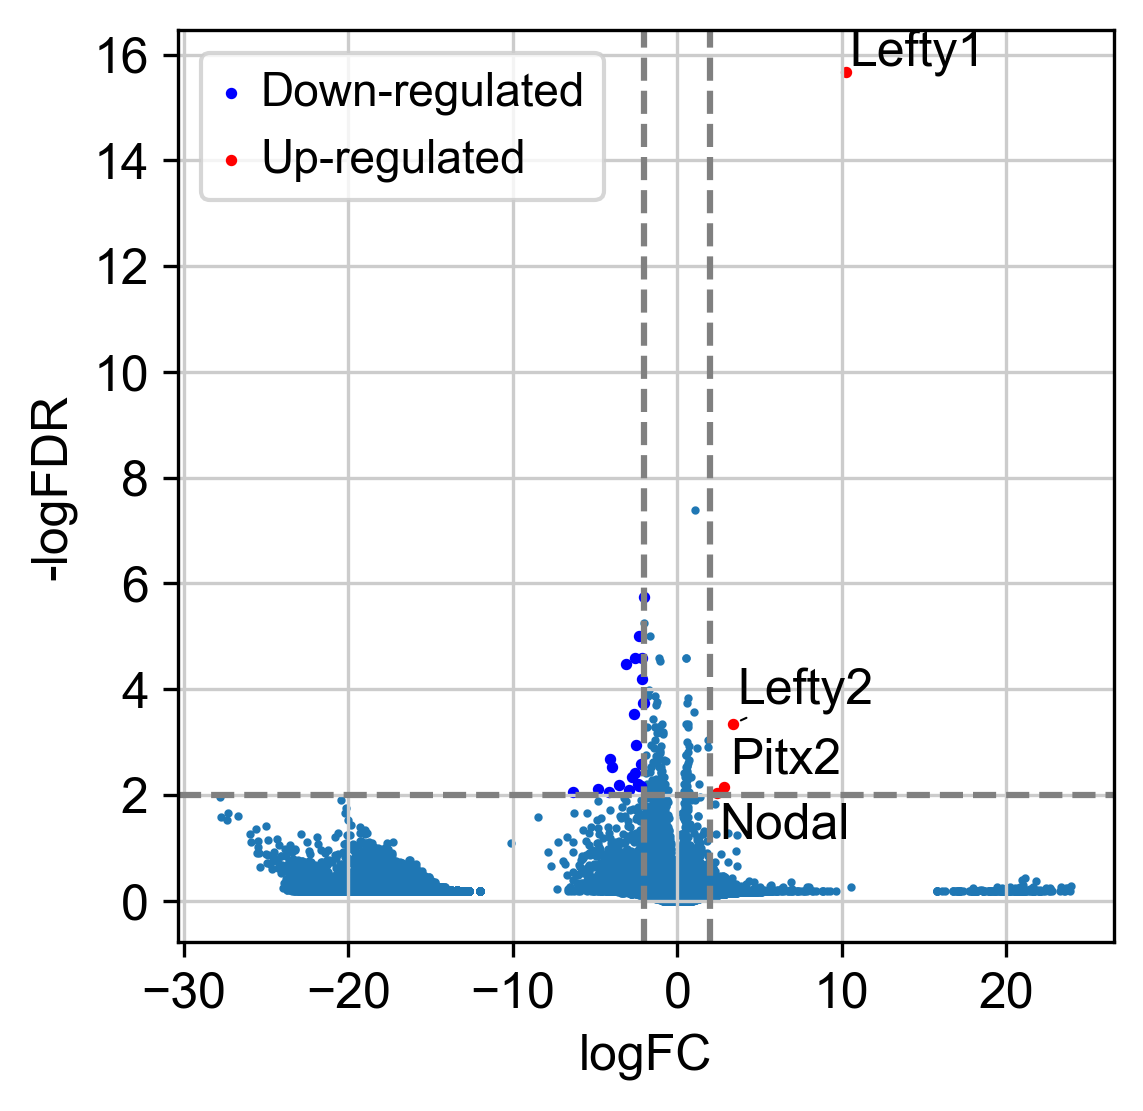

In [130]:
from adjustText import adjust_text

plt.scatter(x=df['logfoldchanges'],y=df['pvals_adj'].apply(lambda x:-np.log10(x)),s=1)

# highlight down- or up- regulated genes
down = df[(df['logfoldchanges']<=-2)&(df['pvals_adj']<=0.01)]
up = df[(df['logfoldchanges']>=2)&(df['pvals_adj']<=0.01)]

plt.scatter(x=down['logfoldchanges'],y=down['pvals_adj'].apply(lambda x:-np.log10(x)),s=3,label="Down-regulated",color="blue")
plt.scatter(x=up['logfoldchanges'],y=up['pvals_adj'].apply(lambda x:-np.log10(x)),s=3,label="Up-regulated",color="red")
texts=[]
for i,r in up.iterrows():
    texts.append(plt.text(x=r['logfoldchanges'],y=-np.log10(r['pvals_adj']),s=r[0]))
adjust_text(texts,arrowprops=dict(arrowstyle="-", color='black', lw=0.5))
plt.xlabel("logFC")
plt.ylabel("-logFDR")
plt.axvline(-2,color="grey",linestyle="--")
plt.axvline(2,color="grey",linestyle="--")
plt.axhline(2,color="grey",linestyle="--")
plt.legend()